In [1]:
import torch
import os
from PIL import Image
from pathlib import Path
import pandas as pd
import torchvision
from sklearn.model_selection import train_test_split

In [2]:
labels=pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
train,valid=train_test_split(labels,train_size=0.8,shuffle=True,stratify=labels['breed'],random_state=42)

In [3]:
train,train_labels=train['id'].reset_index(drop=True),train['breed'].reset_index(drop=True)
val,val_labels=valid['id'].reset_index(drop=True),valid['breed'].reset_index(drop=True)

In [4]:
'''Encoding labels'''

breeds=dict()
breed_count=1

for breed in labels['breed'].value_counts().index:

    breeds[breed]=breed_count-1
    breed_count+=1

val_labels_torch=torch.zeros(len(val_labels),1)
train_labels_torch=torch.zeros(len(train_labels),1)

for index in val_labels.index:
    val_labels_torch[index]=breeds[val_labels.iloc[index]]

for index in train_labels.index:
    train_labels_torch[index]=breeds[train_labels.iloc[index]]

val_labels_torch = val_labels_torch.long()
train_labels_torch = train_labels_torch.long()


val_labels_torch[91]
# val_labels=torch.tensor(val_labels.values)
# train_labels=torch.tensor(train_labels.values)

tensor([21])

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor()
])


def create_dataset(series, directory_path, transform):
    tensors = []
    for i in range(len(series)):
        if(series[i].endswith('.jpg')):
            img_file=series[i]
        else:
            img_file = series[i] + '.jpg'
        img_path = os.path.join(directory_path, img_file)
        img = Image.open(img_path).convert('RGB')  # Ensure RGB
        img_t = transform(img)
        tensors.append(img_t)
    return torch.stack(tensors, dim=0)


In [6]:
directory_path=Path('/kaggle/input/dog-breed-identification/train')
train_dataset=create_dataset(train,directory_path,transform)

In [7]:


# For validation: no augmentation
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
val_dataset = create_dataset(val, directory_path, transform=val_transform)


In [8]:
from torch.utils.data import TensorDataset

train_dataset_torch=TensorDataset(train_dataset,train_labels_torch)
val_dataset_torch=TensorDataset(val_dataset,val_labels_torch)

In [9]:
train_dataset.shape,train_labels_torch.shape

(torch.Size([8177, 3, 224, 224]), torch.Size([8177, 1]))

In [10]:
val_dataset_torch[0]

(tensor([[[0.2980, 0.2667, 0.1569,  ..., 0.2510, 0.0471, 0.0353],
          [0.2275, 0.1490, 0.2157,  ..., 0.1020, 0.0196, 0.0078],
          [0.2000, 0.1098, 0.2745,  ..., 0.0510, 0.0275, 0.0157],
          ...,
          [0.1176, 0.2118, 0.1843,  ..., 0.1176, 0.1373, 0.1451],
          [0.1490, 0.1843, 0.1804,  ..., 0.1765, 0.1569, 0.1451],
          [0.2431, 0.2784, 0.2118,  ..., 0.1529, 0.1216, 0.1059]],
 
         [[0.3765, 0.3373, 0.2275,  ..., 0.2863, 0.0549, 0.0314],
          [0.3137, 0.2314, 0.2980,  ..., 0.1373, 0.0275, 0.0039],
          [0.2941, 0.2039, 0.3647,  ..., 0.0824, 0.0392, 0.0157],
          ...,
          [0.1176, 0.2118, 0.1882,  ..., 0.1333, 0.1529, 0.1608],
          [0.1490, 0.1843, 0.1843,  ..., 0.1843, 0.1647, 0.1529],
          [0.2431, 0.2784, 0.2157,  ..., 0.1569, 0.1255, 0.1059]],
 
         [[0.3765, 0.3608, 0.2588,  ..., 0.2235, 0.0431, 0.0510],
          [0.2667, 0.2000, 0.2706,  ..., 0.0745, 0.0157, 0.0235],
          [0.1961, 0.1176, 0.2902,  ...,

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights

# 載入預訓練 DenseNet121
densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

# 凍結大部分層，只微調 classifier
for param in densenet.features.parameters():
    param.requires_grad = False

# 替換 classifier 為自訂 head（適用 120 類別）
densenet.classifier = nn.Sequential(
    nn.Linear(densenet.classifier.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 120)
)

# 移動到 GPU
model_torch = densenet.to("cuda")

# 定義損失與優化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 86.4MB/s]


In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_torch, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset_torch, batch_size=64, shuffle=False)

n_epochs = 20
train_losses, val_losses, accuracies = [], [], []
best_acc = 0.0

for epoch in range(1, n_epochs + 1):
    model_torch.train()
    total_train_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to('cuda')
        labels = labels.to('cuda').squeeze(1)
        optimizer.zero_grad()
        outputs = model_torch(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # 驗證
    model_torch.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to('cuda')
            labels = labels.to('cuda').squeeze(1)
            outputs = model_torch(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    scheduler.step()

    # 儲存最高準確模型
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model_torch.state_dict(), 'densenet121_best.pth')

    # 紀錄
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    accuracies.append(accuracy)

    print(f"Epoch [{epoch}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Acc: {accuracy:.2f}%")


Epoch [1/20], Train Loss: 3.3257, Val Loss: 2.0944, Acc: 62.35%
Epoch [2/20], Train Loss: 1.6708, Val Loss: 1.3732, Acc: 72.08%
Epoch [3/20], Train Loss: 1.1634, Val Loss: 1.1292, Acc: 73.20%
Epoch [4/20], Train Loss: 0.9379, Val Loss: 1.0242, Acc: 74.72%
Epoch [5/20], Train Loss: 0.7904, Val Loss: 0.9574, Acc: 75.01%
Epoch [6/20], Train Loss: 0.7043, Val Loss: 0.9283, Acc: 75.45%
Epoch [7/20], Train Loss: 0.6452, Val Loss: 0.9035, Acc: 76.14%
Epoch [8/20], Train Loss: 0.6032, Val Loss: 0.9058, Acc: 75.79%
Epoch [9/20], Train Loss: 0.5727, Val Loss: 0.8927, Acc: 76.28%
Epoch [10/20], Train Loss: 0.5643, Val Loss: 0.8977, Acc: 76.48%
Epoch [11/20], Train Loss: 0.5643, Val Loss: 0.8937, Acc: 76.48%
Epoch [12/20], Train Loss: 0.5674, Val Loss: 0.8873, Acc: 76.58%
Epoch [13/20], Train Loss: 0.5632, Val Loss: 0.8793, Acc: 76.53%
Epoch [14/20], Train Loss: 0.5520, Val Loss: 0.8860, Acc: 76.19%
Epoch [15/20], Train Loss: 0.5337, Val Loss: 0.8665, Acc: 76.38%
Epoch [16/20], Train Loss: 0.5070,

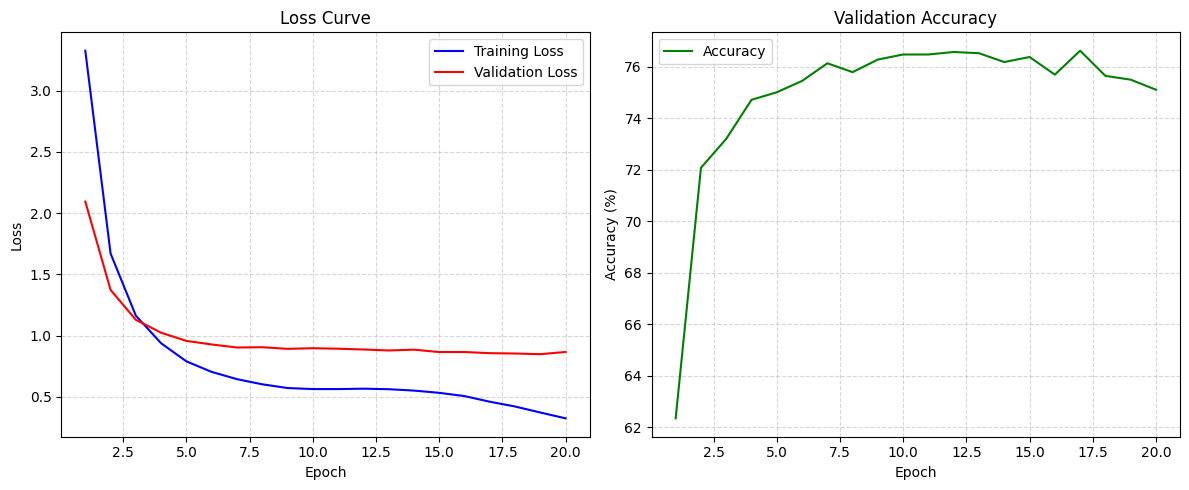

In [13]:
import matplotlib.pyplot as plt  # ← 加上這行

plt.figure(figsize=(12, 5))

# 子圖1：損失曲線
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, n_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 子圖2：準確率曲線
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), accuracies, 'g-', label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


In [14]:
torch.save(densenet.state_dict(), 'densenet_custom_head.pth')



In [15]:
os.listdir('/kaggle/input/dog-breed-identification/test')[1:10]

['f7a32505c12649183c5991ecfa7d68b3.jpg',
 'bc6d50ffb4644feb34530aa58943e85b.jpg',
 '7cbc041e79135a572aad87904b5c9c57.jpg',
 'f3b603f10d6a344f0395fb46b242ff8e.jpg',
 'db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '665bab06a3ea861c0812c778486988e3.jpg',
 '7b57911ea7559cebd6db308125926642.jpg',
 'df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 'b80d89ad4a17ac2537ff46d251efcd7c.jpg']

In [16]:

test=os.listdir('/kaggle/input/dog-breed-identification/test')
test_dataset=create_dataset(test,'/kaggle/input/dog-breed-identification/test',val_transform)
test_dataset=test_dataset.to(device='cuda')

In [17]:
import pandas as pd
output=pd.DataFrame(columns=['id',*breeds.keys()])

In [18]:
output

,id,scottish_deerhound,maltese_dog,afghan_hound,entlebucher,bernese_mountain_dog,shih-tzu,pomeranian,great_pyrenees,basenji,...,otterhound,giant_schnauzer,walker_hound,tibetan_mastiff,german_shepherd,golden_retriever,komondor,brabancon_griffon,eskimo_dog,briard


In [19]:
breeds

{'scottish_deerhound': 0,
 'maltese_dog': 1,
 'afghan_hound': 2,
 'entlebucher': 3,
 'bernese_mountain_dog': 4,
 'shih-tzu': 5,
 'pomeranian': 6,
 'great_pyrenees': 7,
 'basenji': 8,
 'samoyed': 9,
 'tibetan_terrier': 10,
 'airedale': 11,
 'cairn': 12,
 'leonberg': 13,
 'japanese_spaniel': 14,
 'beagle': 15,
 'blenheim_spaniel': 16,
 'miniature_pinscher': 17,
 'australian_terrier': 18,
 'irish_wolfhound': 19,
 'saluki': 20,
 'lakeland_terrier': 21,
 'papillon': 22,
 'norwegian_elkhound': 23,
 'siberian_husky': 24,
 'whippet': 25,
 'pug': 26,
 'chow': 27,
 'italian_greyhound': 28,
 'pembroke': 29,
 'newfoundland': 30,
 'ibizan_hound': 31,
 'border_terrier': 32,
 'silky_terrier': 33,
 'lhasa': 34,
 'dandie_dinmont': 35,
 'bedlington_terrier': 36,
 'sealyham_terrier': 37,
 'rhodesian_ridgeback': 38,
 'irish_setter': 39,
 'boston_bull': 40,
 'old_english_sheepdog': 41,
 'collie': 42,
 'english_foxhound': 43,
 'african_hunting_dog': 44,
 'bouvier_des_flandres': 45,
 'schipperke': 46,
 'kelp

In [20]:
import torch.nn.functional as F
i=0
for file,sample in zip(os.listdir('/kaggle/input/dog-breed-identification/test'),test_dataset):
    sample=sample.cuda()
    output_values=model_torch(sample.unsqueeze(dim=0))
    output_values=output_values.cpu()
    probabilities = F.softmax(output_values, dim=1)
    file_id = file.split('.')[0]  # 移除 .jpg 副檔名
    output.loc[i] = [file_id, *probabilities[0].detach().numpy()] 
    i+=1

In [21]:
output.head()

,id,scottish_deerhound,maltese_dog,afghan_hound,entlebucher,bernese_mountain_dog,shih-tzu,pomeranian,great_pyrenees,basenji,...,otterhound,giant_schnauzer,walker_hound,tibetan_mastiff,german_shepherd,golden_retriever,komondor,brabancon_griffon,eskimo_dog,briard
0,09e51e17e2b756ff2ace8a87bd1443fa,3.414235e-05,1.936534e-05,1.735170e-06,3.241295e-06,5.209019e-06,0.000004,3.680350e-06,1.383388e-05,0.000219,...,2.037836e-06,8.116509e-05,1.848342e-05,4.494328e-06,6.350233e-06,3.832077e-07,0.000015,0.000166,0.000015,4.251152e-06
1,f7a32505c12649183c5991ecfa7d68b3,5.069889e-07,1.455868e-05,4.896053e-06,4.631250e-07,6.207441e-07,0.000006,2.960831e-06,2.516487e-06,0.000009,...,5.408787e-07,1.554561e-07,3.218663e-06,2.281007e-06,3.051586e-06,8.105076e-05,0.000001,0.000007,0.000002,3.135941e-07
2,bc6d50ffb4644feb34530aa58943e85b,9.272728e-06,1.006515e-05,4.155703e-04,2.091982e-05,4.354836e-04,0.000007,2.589571e-04,6.622078e-03,0.000021,...,1.598692e-04,4.603277e-05,1.719547e-05,1.664036e-02,4.281854e-04,2.462924e-01,0.000033,0.001113,0.000054,1.186691e-03
3,7cbc041e79135a572aad87904b5c9c57,1.248763e-04,5.061478e-07,6.861699e-07,5.351159e-07,2.293763e-07,0.000003,1.054555e-06,5.904981e-07,0.000027,...,2.566187e-09,1.109785e-06,6.045100e-07,5.018852e-09,7.351229e-09,2.921197e-08,0.000001,0.000004,0.000003,1.280789e-07
4,f3b603f10d6a344f0395fb46b242ff8e,4.568638e-07,1.029958e-06,2.364777e-06,1.597673e-05,1.751718e-05,0.000018,1.757736e-07,8.066576e-07,0.000021,...,4.904508e-06,2.957202e-07,1.897654e-03,1.288468e-07,2.869812e-07,1.414639e-06,0.000001,0.000003,0.000002,2.413087e-07


In [22]:
output.to_csv('test_submission.csv',index=False)